# Tests for the server

I'm using very popular httpx as the client to test the server
it's a good measure to test the server, to see if the server is up to the standard of HTTP protocol

In [8]:
# %pip install httpx
# %pip install "glow-cli"
# %pip install pandas
# %pip install matplotlib

In [26]:
from tcp_server import Request, Response
import socket
from json import dumps
from matplotlib import pyplot as plt

import httpx

from glow.colors import cprint

import concurrent.futures
from typing import Optional
from datetime import datetime
import pandas as pd

PROTOCOL = "https"
PORT = 8000
HOST = "localhost"

test_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)


In [13]:
STATUS_CODES = {
    200: "OK (the request was SUCCESSFUL)",
    302: "Found (REDIRECT to a different URL)",
    401: "Unauthorized (the user is NOT authorized)",
    404: "Not Found (the resource was NOT found)",
    405: "Method Not Allowed (the method is NOT allowed for the requested resource)",
    500: "Internal Server Error (the server encountered an ERROR while processing the request)",
}


In [10]:
def response_to_raw(response: httpx.Response) -> str:
    """
    Return in the format of HTTP response
    Print as much detail from other network layers as possible
    """
    # Build the raw HTTP response string
    raw_response = f"HTTP/{response.http_version} {response.status_code} {response.reason_phrase}\r\n"

    for name, value in response.headers.items():
        raw_response += f"{name}: {value}\r\n"
    raw_response += "\r\n"
    raw_response += response.text

    return raw_response

In [68]:
def client_core(method, path, headers=None, json=None, with_cert=True):
    """
    Core function for the client
    """
    with httpx.Client(verify=False, cert=("cert.pem", "key.pem") if with_cert else None) as client:
        url = f"{PROTOCOL}://{HOST}:{PORT}{path}"
        response = client.request(method, url, headers=headers, json=json)
    return response

In [69]:
def test_endpoint(path, method, headers=None, json=None, with_cert=True):
    """
    Print the request and response in a readable format
    """
    cprint("================ REQUEST ================", "header")
    cprint(f"[{method}] '{path}'", "header")
    if headers is not None:
        for key, value in headers.items():
            cprint(f"{key}: {value}", "header")

    if json is not None:
        print()
        cprint("BODY DATA", "header")
        cprint(dumps(json, indent=4), "header")

    response = client_core(method, path, headers, json, with_cert)

    cprint("================ RESPONSE ================", "green")
    cprint(f"STATUS: {response.status_code}: {STATUS_CODES[response.status_code]}", "green")
    cprint("\nRAW RESPONSE:", "green")
    cprint(response_to_raw(response), "green")
    print()
    return response


## Different useful headers

In [14]:

USUAL_HEADERS = {
    "Host": "localhost:8000",
    "Connection": "keep-alive",
    "sec-ch-ua": '"Not;A=Brand";v="24", "Chromium";v="128"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "Upgrade-Insecure-Requests": "1",
    "DNT": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Sec-Fetch-Site": "cross-site",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-User": "?1",
    "Sec-Fetch-Dest": "document",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "en-US,en;q=0.9",
}

LOGOUT_HEADER = dict(
    **USUAL_HEADERS,
    Cookie="_xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2FaTFlFZlAtY2pjN1JTMnVQQU9vYURUc2k5Q0xpNmZLME9fNGJFWnU3bFRCMzQ9czk2LWMiLCAiZW1haWwiOiAieHozODdAbmF1LmVkdSIsICJlbWFpbF92ZXJpZmllZCI6IHRydWUsICJoZCI6ICJuYXUuZWR1IiwgInRva2VuIjogImV5SjFjMlZ5SWpvZ2V5SnpkV0lpIn0sICJfc3RhdGVfZ29vZ2xlXzVtTmRuT0VKWG0ycm1OSmlxcmJ4ZzM2ak1OMWtmNCI6IHsiZGF0YSI6IHsicmVkaXJlY3RfdXJpIjogImh0dHBzOi8vbG9jYWxob3N0OjgwMDAvYXV0aD9leHRlbnNpb25faWQ9Z2JjbWJvcHBiYmZqaGRwbGltam5kbmtoYmplb2xiamkiLCAibm9uY2UiOiAiMTBvMXFtdFZaY1d3YVFqU0hhUVgiLCAidXJsIjogImh0dHBzOi8vYWNjb3VudHMuZ29vZ2xlLmNvbS9vL29hdXRoMi92Mi9hdXRoP3Jlc3BvbnNlX3R5cGU9Y29kZSZjbGllbnRfaWQ9MjIwNDU4OTY2MjQ0LWxvbzdwajdxMmRpYnU0dTBmYmdwczZxbTg0NjZpZG9tLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tJnJlZGlyZWN0X3VyaT1odHRwcyUzQSUyRiUyRmxvY2FsaG9zdCUzQTgwMDAlMkZhdXRoJTNGZXh0ZW5zaW9uX2lkJTNEZ2JjbWJvcHBiYmZqaGRwbGltam5kbmtoYmplb2xiamkmc2NvcGU9b3BlbmlkK2VtYWlsK3Byb2ZpbGUmc3RhdGU9NW1OZG5PRUpYbTJybU5KaXFyYnhnMzZqTU4xa2Y0Jm5vbmNlPTEwbzFxbXRWWmNXd2FRalNIYVFYIn0sICJleHAiOiAxNzMzNDU4NTE2LjQ0NjE4NDl9fQ==.0ad325a3a8a407a804919af7bffe35d3fdb9816f06ee376d110cedde1effb7ad",
)

LOGIN_HEADER = dict(
    **USUAL_HEADERS,
    Cookie="_xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=",
)

AUTH_HEADER = dict(
    **USUAL_HEADERS,
    Cookie="_xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2FaTFlFZlAtY2pjN1JTMnVQQU9vYURUc2k5Q0xpNmZLME9fNGJFWnU3bFRCMzQ9czk2LWMiLCAiZW1haWwiOiAieHozODdAbmF1LmVkdSIsICJlbWFpbF92ZXJpZmllZCI6IHRydWUsICJoZCI6ICJuYXUuZWR1In19.101086856aac8d049f71f21941f0f0bb7b78aa5415bde84cb93f3de339cdb378",
)

AUTH_LINK = "/auth?extension_id=gbcmboppbbfjhdplimjndnkhbjeolbji&state=51gZK0gvP8cvhjuO0m2nty3nkSIUy9&code=4%2F0AeanS0bvEfVN5JHHzmCFxCjoW05Msq5TwNRFBoka-tIbxoCa27ebMDw53PZf9YyD8yDaAw&scope=email+profile+openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.profile+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&authuser=0&hd=nau.edu&prompt=consent"

AUTHORIZED_HEADER = dict(
    **USUAL_HEADERS,
    Cookie="_xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2FaTFlFZlAtY2pjN1JTMnVQQU9vYURUc2k5Q0xpNmZLME9fNGJFWnU3bFRCMzQ9czk2LWMiLCAiZW1haWwiOiAieHozODdAbmF1LmVkdSIsICJlbWFpbF92ZXJpZmllZCI6IHRydWUsICJoZCI6ICJuYXUuZWR1In19.101086856aac8d049f71f21941f0f0bb7b78aa5415bde84cb93f3de339cdb378",
)

WRONG_TOKEN_HEADER = dict(
    **USUAL_HEADERS,
    Cookie="_xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=lifeIsLikeaBoxOfChocolates",
)

## Test endpoints

Please make sure `python app.py --log_level=DEBUG` is running

### Unprotected endpoints
> What to test?
* Usual GET request
* Status code
* JSON response body


In [17]:
response = test_endpoint("/naked", "GET")
assert response.status_code == 200
assert len(response.json()) == 1

================ REQUEST ================
[GET] '/naked'
================ RESPONSE ================
STATUS: 200: OK (the request was SUCCESSFUL)

RAW RESPONSE:
HTTP/HTTP/1.1 200 OK
content-type: application/json
date: Thu, 05 Dec 2024 22:51:42 GMT
set-cookie: session=

{"message": "This is a naked endpoint, not protected by auth"}



### Logout
> What to test?
* Session management
* Redirect response/ Status code.


In [18]:
response = test_endpoint("/logout", "GET", headers=LOGOUT_HEADER)
assert response.status_code == 302

================ REQUEST ================
[GET] '/logout'
Host: localhost:8000
Connection: keep-alive
sec-ch-ua: "Not;A=Brand";v="24", "Chromium";v="128"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "macOS"
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7
Sec-Fetch-Site: cross-site
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br, zstd
Accept-Language: en-US,en;q=0.9
Cookie: _xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2FaTFlF

### Unauthorized endpoints
> What to test?
* Session management
* Status code
* JWT guarding the path
* JSON response body


In [20]:
response = test_endpoint("/my_profile", "GET")
assert response.status_code == 401

================ REQUEST ================
[GET] '/my_profile'
================ RESPONSE ================
STATUS: 401: Unauthorized (the user is NOT authorized)

RAW RESPONSE:
HTTP/HTTP/1.1 401 
content-type: application/json
date: Thu, 05 Dec 2024 22:54:50 GMT
set-cookie: session=

{"error": "Unauthorized"}



### Login
> What to test?
* Session management (set the cookie)
* Redirect response/ Status code.
* JWT working with google oauth

In [21]:
response = test_endpoint("/login?extension_id=gbcmboppbbfjhdplimjndnkhbjeolbji", "GET", headers=LOGIN_HEADER)
assert response.status_code == 302

================ REQUEST ================
[GET] '/login?extension_id=gbcmboppbbfjhdplimjndnkhbjeolbji'
Host: localhost:8000
Connection: keep-alive
sec-ch-ua: "Not;A=Brand";v="24", "Chromium";v="128"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "macOS"
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7
Sec-Fetch-Site: cross-site
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br, zstd
Accept-Language: en-US,en;q=0.9
Cookie: _xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=
================ RESPONSE ================
STATUS: 302: Found (REDIRECT to a different URL)

RAW RESPONSE:
HTTP/HTTP/1.1 302 
content-type: text/html
date: Thu, 05 Dec 2024 22:55:32 GMT
location

### Authorized endpoints
> What to test?
* Session management 
    * JWT is valid when visiting the same path
    * A success authorized response will contain the set-cookie header
* JWT decryption, recover user information (return json data is extracted from the token)
* JSON response body


In [22]:
response = test_endpoint("/my_profile", "GET", headers=AUTHORIZED_HEADER)
assert response.status_code == 200

================ REQUEST ================
[GET] '/my_profile'
Host: localhost:8000
Connection: keep-alive
sec-ch-ua: "Not;A=Brand";v="24", "Chromium";v="128"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "macOS"
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7
Sec-Fetch-Site: cross-site
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br, zstd
Accept-Language: en-US,en;q=0.9
Cookie: _xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2Fa

### Wrong token to test if the JWT can deny the unauthorized user
> What to test?
* Session management, has session, but the wrong token
* Status code/ error message


In [23]:
response = test_endpoint("/my_profile", "GET", headers=WRONG_TOKEN_HEADER)
assert response.status_code == 401

================ REQUEST ================
[GET] '/my_profile'
Host: localhost:8000
Connection: keep-alive
sec-ch-ua: "Not;A=Brand";v="24", "Chromium";v="128"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "macOS"
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7
Sec-Fetch-Site: cross-site
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br, zstd
Accept-Language: en-US,en;q=0.9
Cookie: _xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=lifeIsLikeaBoxOfChocolates
================ RESPONSE ================
STATUS: 401: Unauthorized (the user is NOT authorized)

RAW RESPONSE:
HTTP/HTTP/1.1 401 
content-type: application/json
date: Thu, 05 Dec 2024 23:00:32 GMT
set-cookie

### Path not found
> What to test?
* Path management
* Status code/ error message

In [24]:
response = test_endpoint("/our_profiles", "GET", headers=AUTHORIZED_HEADER)
assert response.status_code == 404

================ REQUEST ================
[GET] '/our_profiles'
Host: localhost:8000
Connection: keep-alive
sec-ch-ua: "Not;A=Brand";v="24", "Chromium";v="128"
sec-ch-ua-mobile: ?0
sec-ch-ua-platform: "macOS"
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7
Sec-Fetch-Site: cross-site
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br, zstd
Accept-Language: en-US,en;q=0.9
Cookie: _xsrf=2|e8ec40bb|be67f97ce63626c0817f331d876587e5|1719595733; session=eyJ1c2VyIjogeyJzdWIiOiAiMTEyMjA4MjUzNzk3MTM1ODU1NDY4IiwgIm5hbWUiOiAiWGlhb2NoZW4gWmhhbmciLCAiZ2l2ZW5fbmFtZSI6ICJYaWFvY2hlbiIsICJmYW1pbHlfbmFtZSI6ICJaaGFuZyIsICJwaWN0dXJlIjogImh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xPa2

### Without SSL certificate
> What to test?
* Previous tests passed because before we use SSL certificate
* The service will refuse the connection.

In [80]:
from httpx import ConnectError
try:
    with httpx.Client() as client:
        response = client.get(f"{PROTOCOL}://{HOST}:{PORT}/my_profile", headers=AUTHORIZED_HEADER)
    response.status_code
except ConnectError:
    print("Without SSL certificate, the connection is refused.")


Without SSL certificate, the connection is refused.


### Invalid JSON to post

In [84]:
with httpx.Client(verify=False) as client:
    response = client.post(f"{PROTOCOL}://{HOST}:{PORT}/sentence_measure/", headers=AUTHORIZED_HEADER, data="- not a json")

print(response.text)
assert response.status_code == 400


{"error": "text_id is required"}


## Concurrency
> What to test?
* Server can handle concurrent requests

But to be honest, the performance test here isn't very meaningful.

As the threading on client and thread pool on server are both on my laptop. Meaning if I start 10 workers' server, the client will have less resources to work on. Not to talk about the database is an on docker postgres also on my laptop.

But here is some running and visualization anyway.

Run the following command in the terminal:
```bash
python app.py --log_level=INFO --n_workers=2
```


In [46]:

def in_concurrent_requesting(
    start_time: datetime,  # pass in from concurrent_requesting
    method: str,
    path: str,
    headers: Optional[dict] = None,
    json: Optional[dict] = None,
):
    """
    A single thread of concurrent requesting
    the very thing we want to duplicate effort on
    """
    thread_start = (datetime.now() - start_time).total_seconds()
    response = client_core(method, path, headers, json)
    thread_end = (datetime.now() - start_time).total_seconds()
    return {
        "status_code": response.status_code,
        "start": thread_start,
        "end": thread_end,
        "round_trip_time": thread_end - thread_start,
    }


def concurrent_requesting(
    n_requests: int,
    n_threads: int,
    method: str,
    path: str,
    headers: Optional[dict] = None,
    json: Optional[dict] = None,
):
    start_time = datetime.now()
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = [
            executor.submit(
                in_concurrent_requesting,
                start_time,
                method,
                path,
                headers,
                json,
            )
            for _ in range(n_requests)
        ]
        df = pd.DataFrame(list(f.result() for f in concurrent.futures.as_completed(futures)))
    return df



In [47]:
perf_df = concurrent_requesting(
    10, 10, "GET", "/naked",
)
perf_df

,status_code,start,end,round_trip_time
0,200,0.002146,0.043950,0.041804
1,200,0.000612,0.044779,0.044167
2,200,0.004874,0.051171,0.046297
3,200,0.004225,0.056942,0.052717
4,200,0.005671,0.066218,0.060547
5,200,0.007387,0.071156,0.063769
6,200,0.009547,0.078371,0.068824
7,200,0.008824,0.119517,0.110693
8,200,0.008981,0.121216,0.112235
9,200,0.007883,0.125158,0.117275


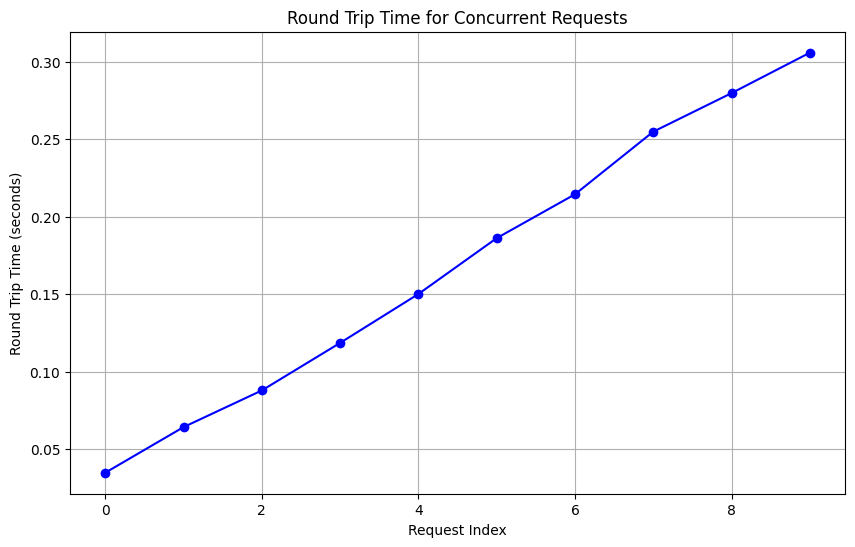

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(perf_df['round_trip_time'], 'bo-')
plt.xlabel('Request Index')
plt.ylabel('Round Trip Time (seconds)') 
plt.title('Round Trip Time for Concurrent Requests')
plt.grid(True)
plt.show()


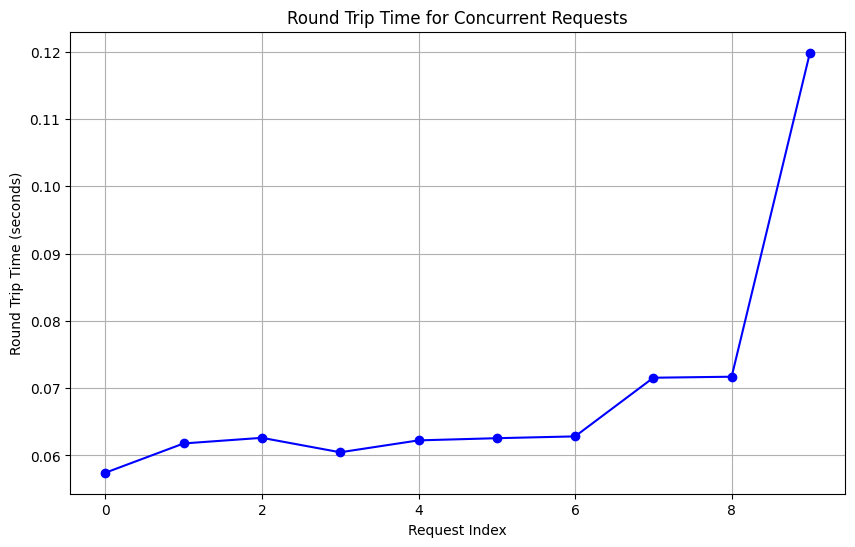

In [51]:
perf_df = concurrent_requesting(
    10, 10, "GET", "/naked",
)

plt.figure(figsize=(10, 6))
plt.plot(perf_df['round_trip_time'], 'bo-')
plt.xlabel('Request Index')
plt.ylabel('Round Trip Time (seconds)') 
plt.title('Round Trip Time for Concurrent Requests')
plt.grid(True)
plt.show()

### Heavy request

#### Workers = 1

In [62]:
perf_df = concurrent_requesting(
    10,
    10,
    "POST",
    "/sentence_measure/",
    headers=AUTHORIZED_HEADER,
    json={"text_id": "readly_2775ecb6"},
)
perf_df

,status_code,start,end,round_trip_time
0,200,0.000830,0.035692,0.034862
1,200,0.000288,0.064576,0.064288
2,200,0.003210,0.091151,0.087941
3,200,0.001190,0.119795,0.118605
4,200,0.003976,0.154123,0.150147
5,200,0.004515,0.190707,0.186192
6,200,0.007697,0.222180,0.214483
7,200,0.004976,0.259850,0.254874
8,200,0.005711,0.285466,0.279755
9,200,0.008449,0.314278,0.305829


We can see the performance is very linear. 1 request has to finish for another to start.

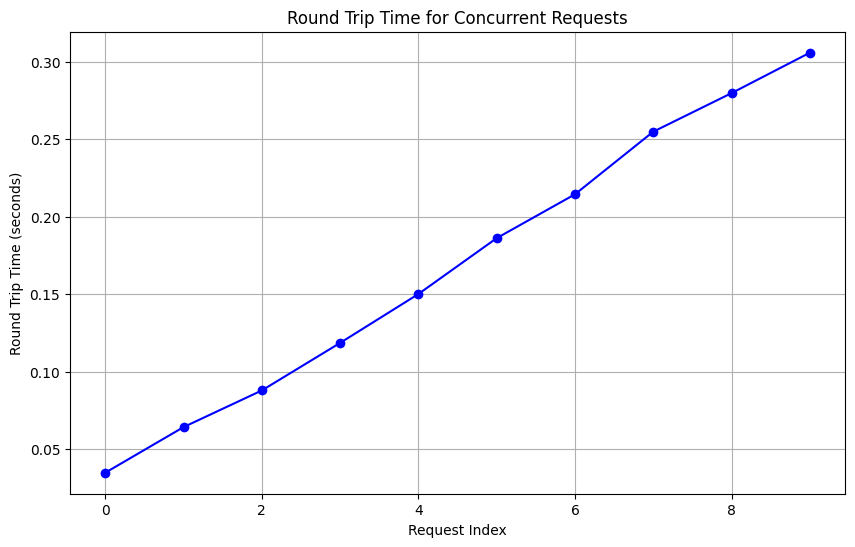

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(perf_df['round_trip_time'], 'bo-')
plt.xlabel('Request Index')
plt.ylabel('Round Trip Time (seconds)') 
plt.title('Round Trip Time for Concurrent Requests')
plt.grid(True)
plt.show()


In [54]:
perf_df = concurrent_requesting(
    10,
    10,
    "POST",
    "/sentence_measure/",
    headers=AUTHORIZED_HEADER,
    json={"text_id": "readly_2775ecb6"},
)
perf_df


,status_code,start,end,round_trip_time
0,200,0.002657,0.255746,0.253089
1,200,0.000913,0.257516,0.256603
2,200,0.003482,0.292921,0.289439
3,200,0.007155,0.308121,0.300966
4,200,0.008934,0.405985,0.397051
5,200,0.005900,0.414676,0.408776
6,200,0.008111,0.434634,0.426523
7,200,0.012845,0.444334,0.431489
8,200,0.011687,0.464757,0.453070
9,200,0.012244,0.479090,0.466846


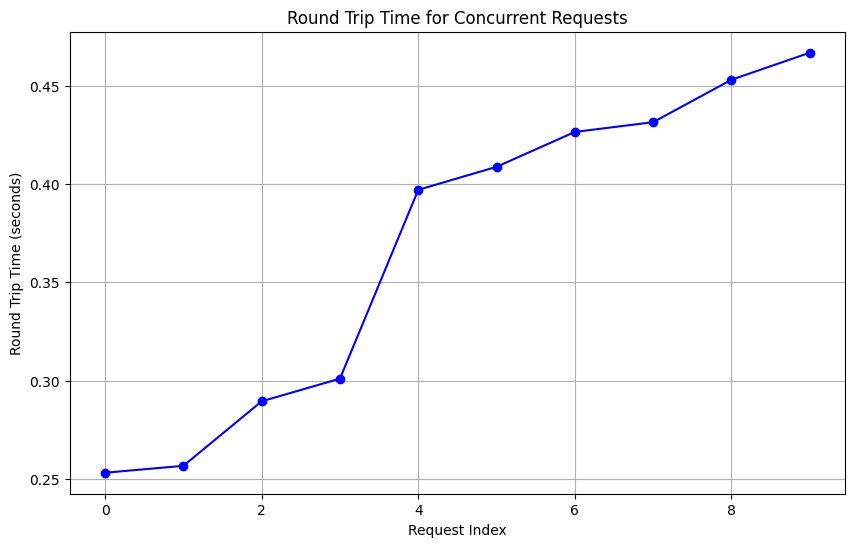

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(perf_df['round_trip_time'], 'bo-')
plt.xlabel('Request Index')
plt.ylabel('Round Trip Time (seconds)') 
plt.title('Round Trip Time for Concurrent Requests')
plt.grid(True)
plt.show()


### Double the number of workers
Let's try n_workers=4

In [52]:
perf_df = concurrent_requesting(
    10,
    10,
    "POST",
    "/sentence_measure/",
    headers=AUTHORIZED_HEADER,
    json={"text_id": "readly_2775ecb6"},
)
perf_df


,status_code,start,end,round_trip_time
0,200,0.004625,0.368440,0.363815
1,200,0.000863,0.368568,0.367705
2,200,0.013332,0.369441,0.356109
3,200,0.007537,0.369733,0.362196
4,200,0.014464,0.417678,0.403214
5,200,0.023967,0.427653,0.403686
6,200,0.035184,0.434944,0.399760
7,200,0.029293,0.442539,0.413246
8,200,0.032119,0.455162,0.423043
9,200,0.045052,0.480227,0.435175


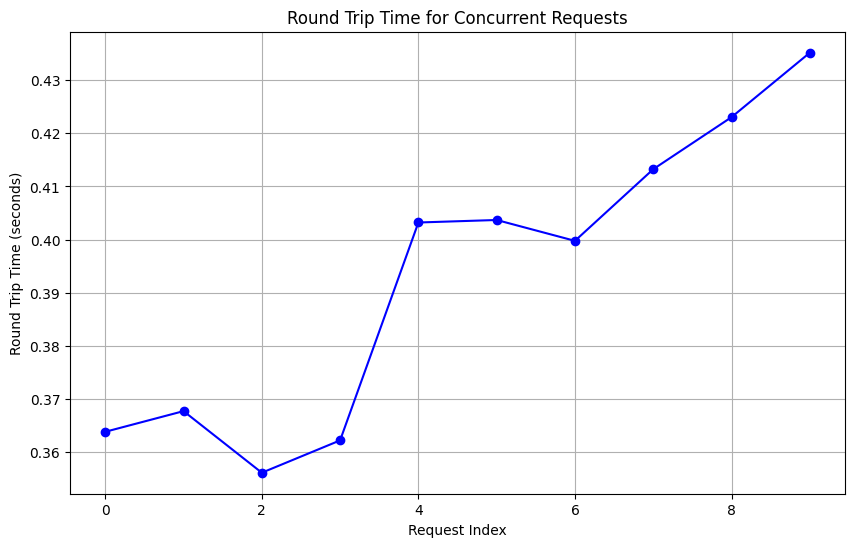

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(perf_df['round_trip_time'], 'bo-')
plt.xlabel('Request Index')
plt.ylabel('Round Trip Time (seconds)') 
plt.title('Round Trip Time for Concurrent Requests')
plt.grid(True)
plt.show()